In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import math
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose, MSTL
import statsmodels.api as sm
from arch.unitroot import PhillipsPerron

In [2]:
df_neutor = pd.read_pickle("/Users/danielzellner/Documents/Studium/Bachelorthesis/src/verkehr_data/df_neutor.pkl")
df_neutor = pd.DataFrame(df_neutor)

In [3]:
df_neutor

,Datum,Zeit,Wochentag,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts,Wetter,Temperatur (°C),Luftfeuchtigkeit (%),Regen (mm),Wind (km/h),Feiertag,Semesterferien,Ferien,Lockdown
0,2018-01-01,00:00:00,Montag,71.0,26.0,45.0,Leichter Regenfall,10.0,83.0,1.0,26.0,1,1,1,0
1,2018-01-01,01:00:00,Montag,67.0,35.0,32.0,Leichter Regenfall,9.0,81.0,1.0,27.0,1,1,1,0
2,2018-01-01,02:00:00,Montag,123.0,53.0,70.0,Mäßiger Regenfall,9.0,79.0,1.0,29.0,1,1,1,0
3,2018-01-01,03:00:00,Montag,171.0,64.0,107.0,Mäßiger Regenfall,8.0,77.0,0.0,31.0,1,1,1,0
4,2018-01-01,04:00:00,Montag,102.0,26.0,76.0,Mäßiger Regenfall,8.0,75.0,0.0,32.0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43814,2022-12-31,18:00:00,Samstag,365.0,173.0,192.0,Bewölkt,16.0,72.0,0.0,38.0,0,1,1,0
43815,2022-12-31,19:00:00,Samstag,303.0,164.0,139.0,Bewölkt,16.0,70.0,0.0,37.0,0,1,1,0
43816,2022-12-31,20:00:00,Samstag,207.0,102.0,105.0,Leicht bewölkt,16.0,69.0,0.0,36.0,0,1,1,0
43817,2022-12-31,21:00:00,Samstag,149.0,83.0,66.0,Leicht bewölkt,15.0,67.0,0.0,36.0,0,1,1,0


## Wie viele Daten fehlen & an welchen Zeitpunkten fehlen die Werte

In [4]:
def missing_values_table(df):

        mis_val = df.isnull().sum()
        
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Summe fehlender Werte', 1 : '% von Gesamt'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% von Gesamt', ascending=False).round(1)
        
        return mis_val_table_ren_columns

missing_values = missing_values_table(df_neutor)
missing_values

,Summe fehlender Werte,% von Gesamt
Neutor FR stadtauswärts,2811,6.4
Neutor FR stadteinwärts,1288,2.9
Neutor (gesamt),1259,2.9
Temperatur (°C),3,0.0
Luftfeuchtigkeit (%),3,0.0
Regen (mm),3,0.0
Wind (km/h),3,0.0


Meisten Daten fehlen in der Zählung der Radfahrer, davon Neutor FR stadtauswärts am meisten
Diese Daten müssen aufgefüllt werden

Die restlichen fehlenden Daten werden in dem Schritt auch aufgefüllt, obwohl es nicht viele sind

Wann fehlen die meisten Daten, sind die gleichmäßig über alle Tageszeiten verteilt, oder sind z.B. in der Nacht besonders viele fehlende Werte?

In [5]:
df_neutor_intervall = df_neutor.copy()

def assign_interval(time):
    if time >= pd.Timedelta(hours=22) or time < pd.Timedelta(hours=6):
        return '22:00 - 05:59'
    elif time >= pd.Timedelta(hours=6) and time < pd.Timedelta(hours=14):
        return '06:00 - 13:59'
    else:
        return '14:00 - 21:59'

df_neutor_intervall['Zeit'] = pd.to_timedelta(df_neutor_intervall['Zeit'].astype(str))

df_neutor_intervall['Zeitintervall'] = df_neutor_intervall['Zeit'].apply(assign_interval)

def count_missing_values(group):
    return group.isnull().sum().sum() 

missing_values_by_interval = df_neutor_intervall.groupby('Zeitintervall').apply(count_missing_values)

print(missing_values_by_interval)

Zeitintervall
06:00 - 13:59    1760
14:00 - 21:59    1760
22:00 - 05:59    1850
dtype: int64


In [6]:
def assign_interval(time):
    if time >= pd.Timedelta(hours=22) or time < pd.Timedelta(hours=6):
        return '22:00 - 05:59'
    elif time >= pd.Timedelta(hours=6) and time < pd.Timedelta(hours=14):
        return '06:00 - 13:59'
    else:
        return '14:00 - 21:59'

missing_values_by_interval = df_neutor_intervall.groupby('Zeitintervall').apply(lambda group: group.isnull().sum())

missing_values_by_interval = missing_values_by_interval.loc[:, missing_values_by_interval.sum() > 0]

print(missing_values_by_interval)


               Neutor (gesamt)  Neutor FR stadteinwärts  \
Zeitintervall                                             
06:00 - 13:59              408                      416   
14:00 - 21:59              408                      416   
22:00 - 05:59              443                      456   

               Neutor FR stadtauswärts  Temperatur (°C)  Luftfeuchtigkeit (%)  \
Zeitintervall                                                                   
06:00 - 13:59                      936                0                     0   
14:00 - 21:59                      936                0                     0   
22:00 - 05:59                      939                3                     3   

               Regen (mm)  Wind (km/h)  
Zeitintervall                           
06:00 - 13:59           0            0  
14:00 - 21:59           0            0  
22:00 - 05:59           3            3  


In [7]:
missing_values_all = df_neutor[df_neutor.isnull().any(axis=1)]
missing_values_all

,Datum,Zeit,Wochentag,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts,Wetter,Temperatur (°C),Luftfeuchtigkeit (%),Regen (mm),Wind (km/h),Feiertag,Semesterferien,Ferien,Lockdown
19631,2020-03-29,03:00:00,Sonntag,NaN,NaN,NaN,weather_condition_null,NaN,NaN,NaN,NaN,0,1,0,2
27601,2021-02-24,04:00:00,Mittwoch,0.0,0.0,NaN,Sonnig,10.0,89.0,0.0,14.0,0,1,0,2
28367,2021-03-28,02:00:00,Sonntag,NaN,NaN,NaN,weather_condition_,NaN,NaN,NaN,NaN,0,1,0,2
31965,2021-08-25,00:00:00,Mittwoch,61.0,NaN,61.0,Leicht bewölkt,14.0,72.0,0.0,8.0,0,1,0,0
31966,2021-08-25,01:00:00,Mittwoch,38.0,NaN,38.0,Leicht bewölkt,14.0,75.0,0.0,7.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35056,2021-12-31,19:00:00,Freitag,142.0,142.0,NaN,Sonnig,13.0,80.0,0.0,24.0,0,1,1,0
35057,2021-12-31,20:00:00,Freitag,64.0,64.0,NaN,Leicht bewölkt,12.0,80.0,0.0,24.0,0,1,1,0
35058,2021-12-31,21:00:00,Freitag,35.0,35.0,NaN,Leicht bewölkt,12.0,79.0,0.0,25.0,0,1,1,0
35059,2021-12-31,22:00:00,Freitag,19.0,19.0,NaN,Leicht bewölkt,12.0,80.0,0.0,27.0,0,1,1,0


In [8]:
missing_per_date = missing_values_all.groupby('Datum').apply(lambda x: x.isnull().sum())
missing_per_date

,Datum,Zeit,Wochentag,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts,Wetter,Temperatur (°C),Luftfeuchtigkeit (%),Regen (mm),Wind (km/h),Feiertag,Semesterferien,Ferien,Lockdown
Datum,,,,,,,,,,,,,,,
2020-03-29,0,0,0,1,1,1,0,1,1,1,1,0,0,0,0
2021-02-24,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2021-03-28,0,0,0,1,1,1,0,1,1,1,1,0,0,0,0
2021-08-25,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0
2021-08-26,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,0,0,0,24,24,24,0,0,0,0,0,0,0,0,0
2021-12-29,0,0,0,3,3,24,0,0,0,0,0,0,0,0,0
2021-12-30,0,0,0,24,24,24,0,0,0,0,0,0,0,0,0


Meisten Daten fehlen für das Jahr 2021, die Monate September, Oktober, November und Dezember fehlen fast vollständig.

# Ausreißer kontrolle

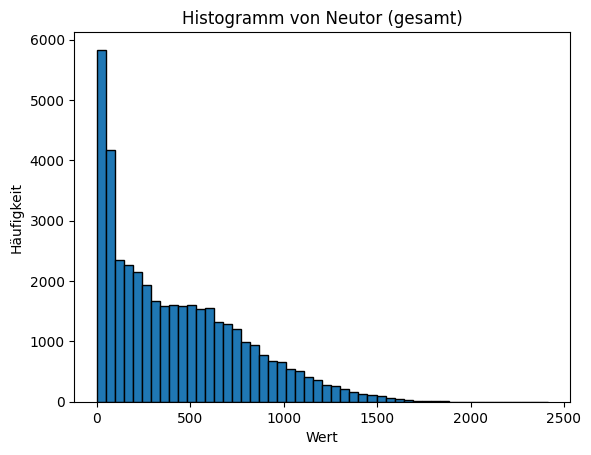

In [9]:
df_histo = df_neutor.dropna()
df_histo = df_histo.drop(['Feiertag', 'Semesterferien', 'Ferien'], axis=1)

plt.hist(df_histo['Neutor (gesamt)'], bins=50, edgecolor='black')
plt.title('Histogramm von Neutor (gesamt)')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.show()

In [10]:
df_neutor_numeric = df_neutor.select_dtypes(include=[np.number])

df_neutor_numeric = df_neutor_numeric.drop(['Feiertag', 'Semesterferien', 'Ferien'], axis=1)

#### Boxplot

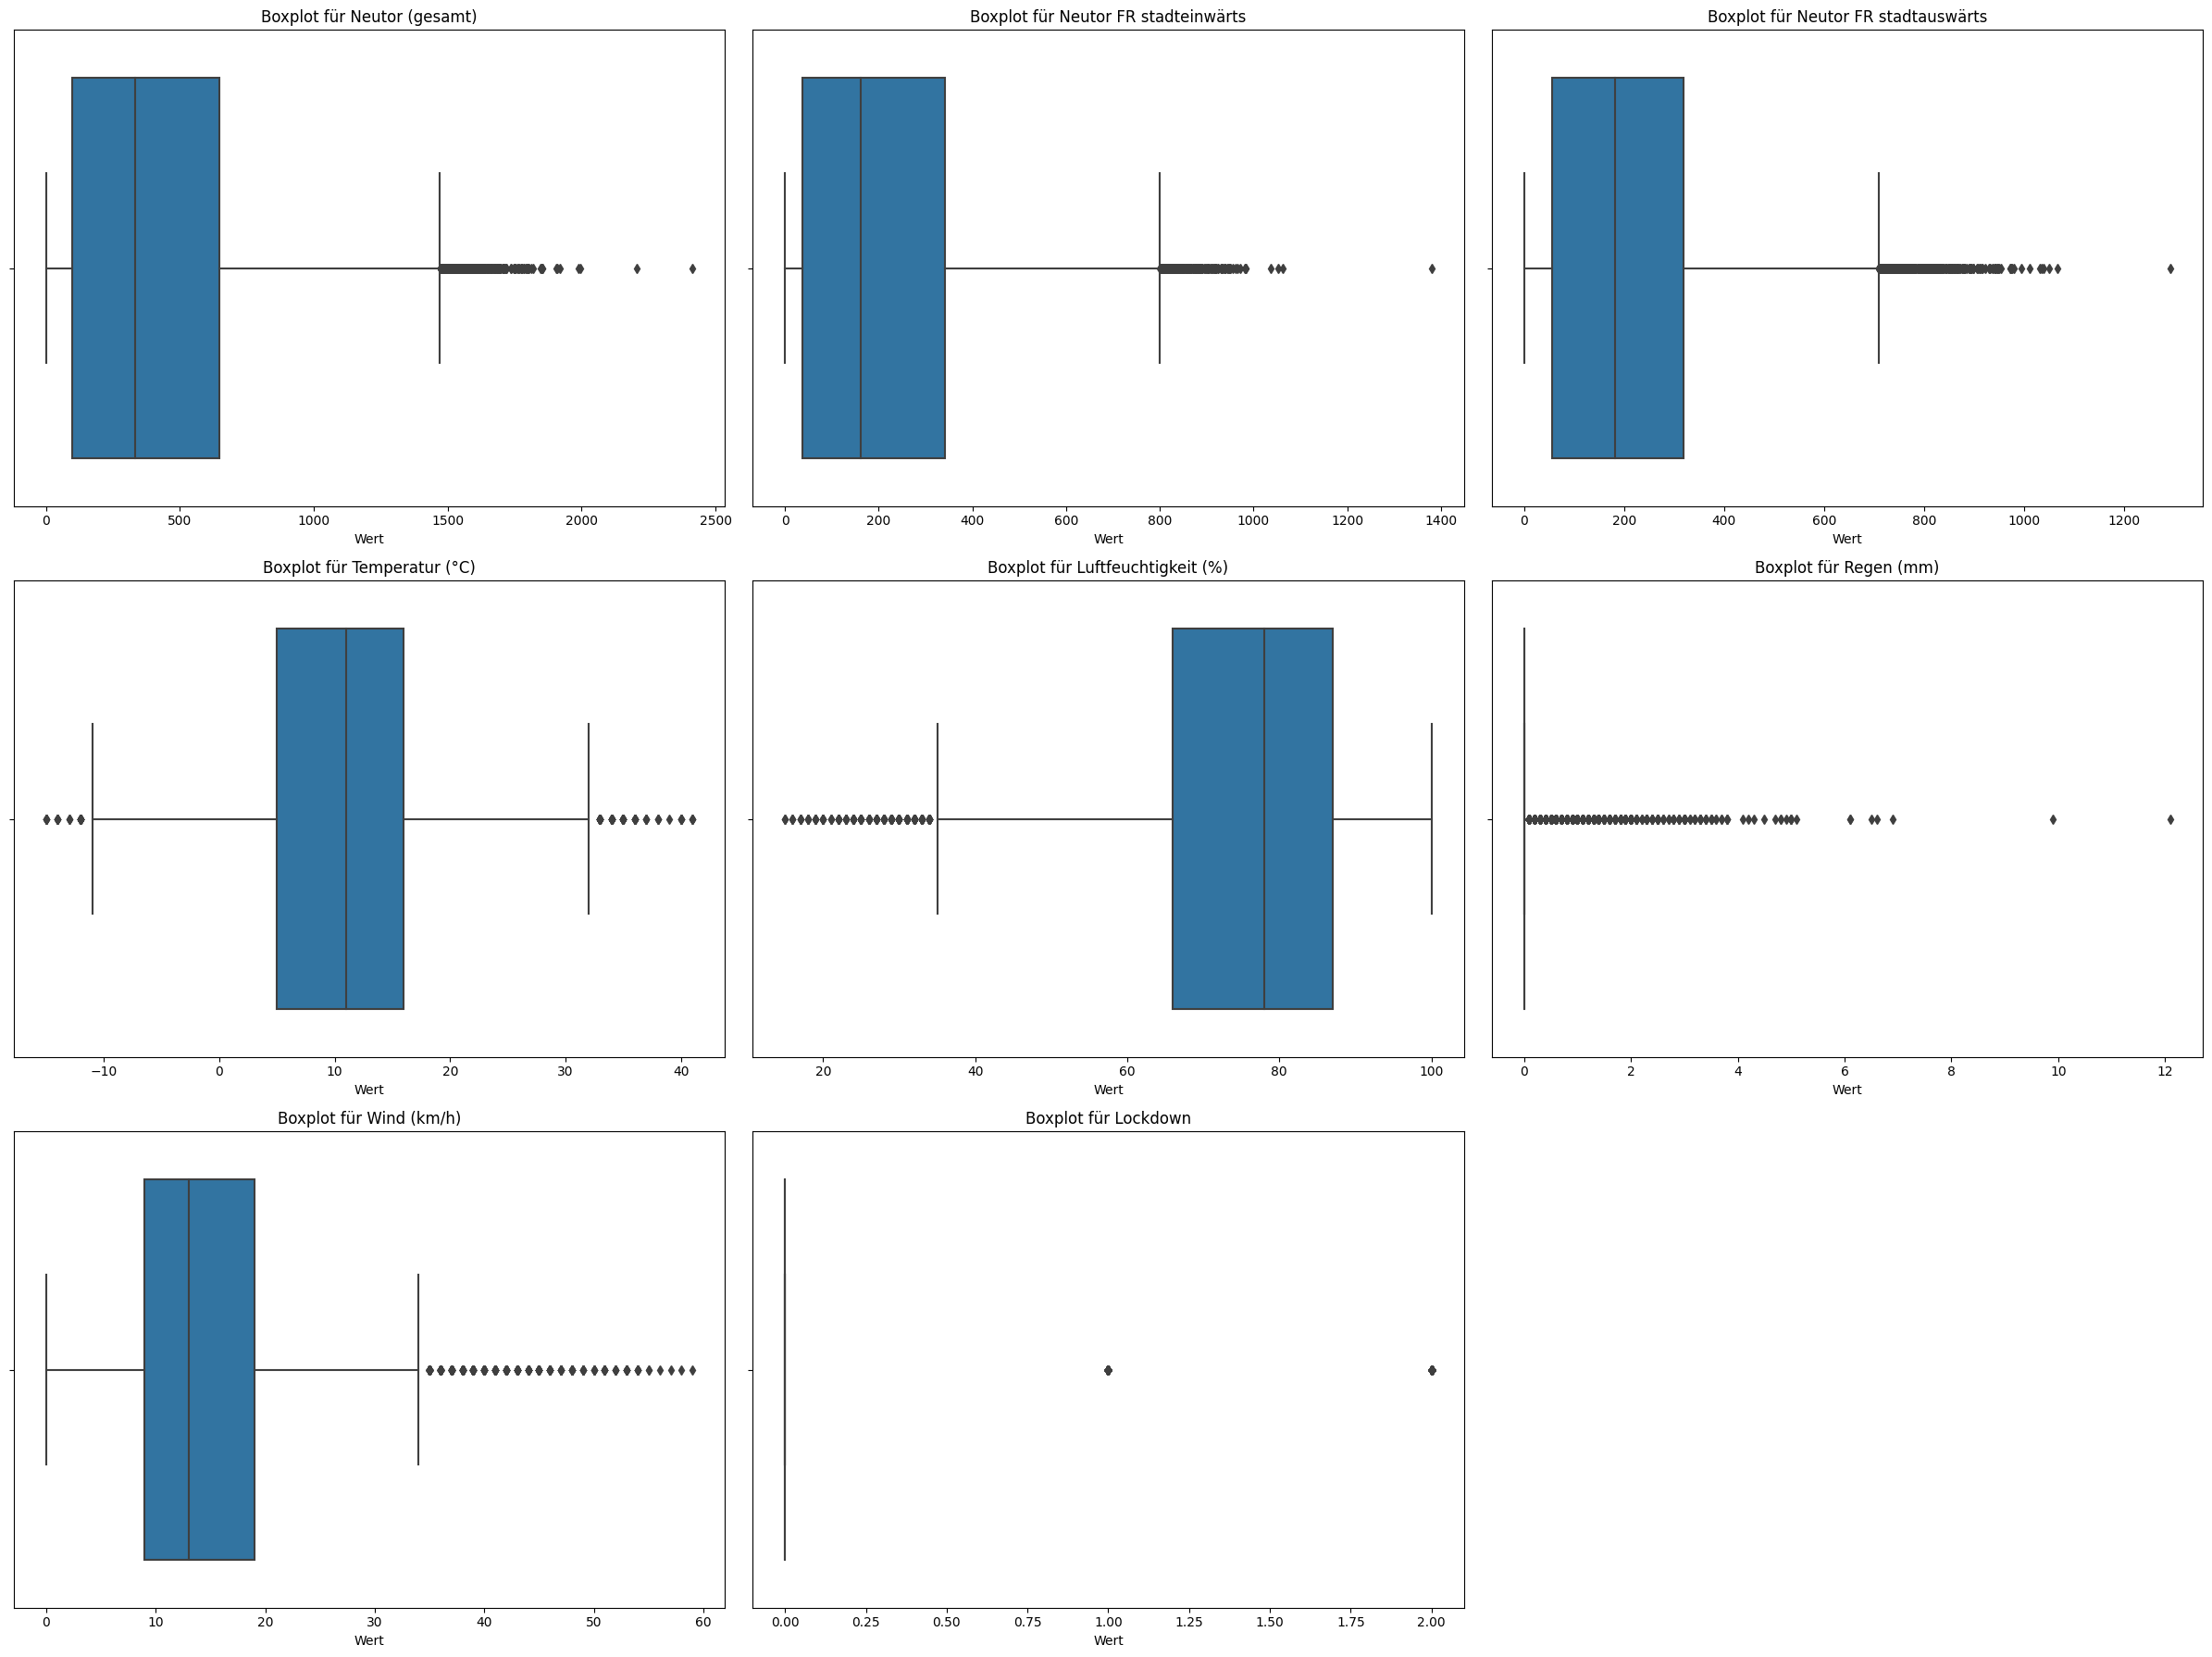

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

n_cols = 3
n_rows = math.ceil(len(df_neutor_numeric.columns) / n_cols)
plt.figure(figsize=(n_cols * 8, n_rows * 6))

for i, col in enumerate(df_neutor_numeric.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=df_neutor[col])
    plt.title(f'Boxplot für {col}')
    plt.xlabel('Wert')

plt.tight_layout()
plt.show()


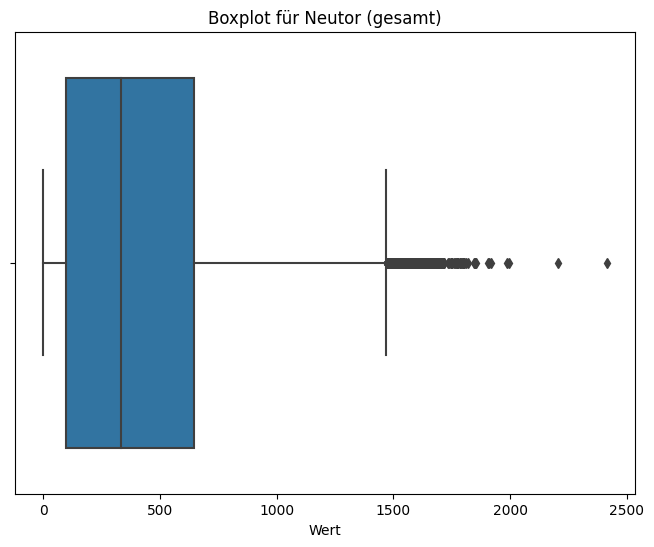

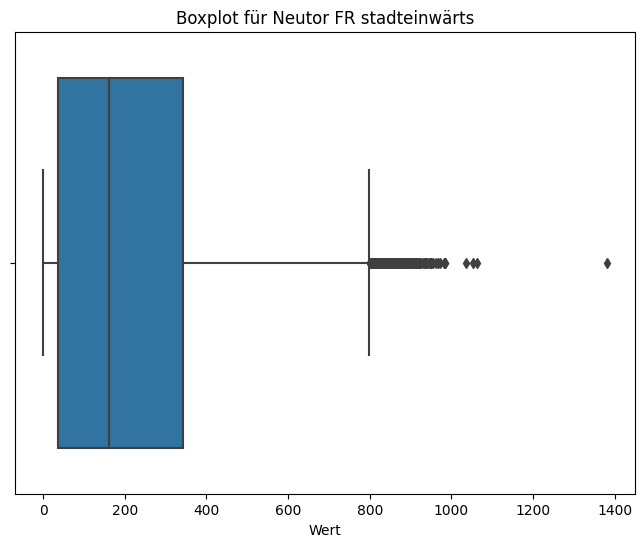

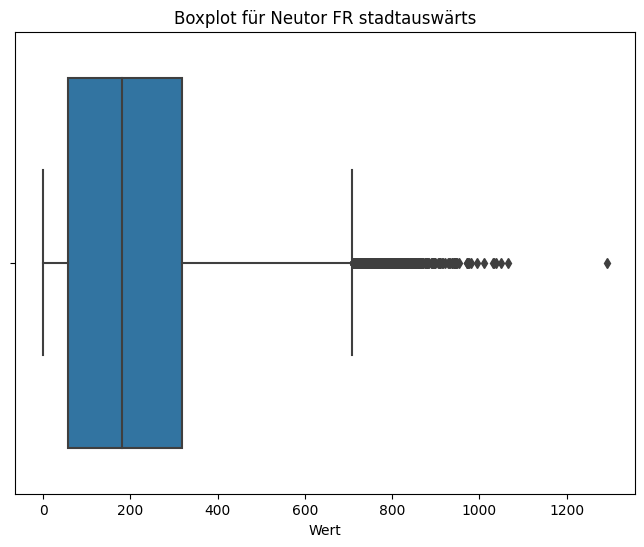

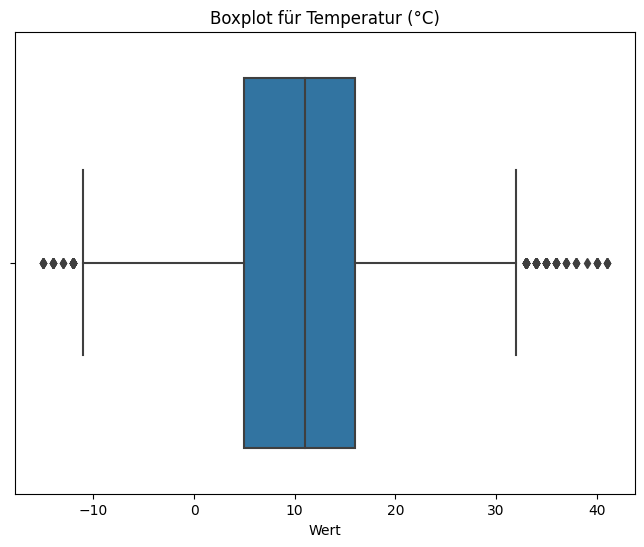

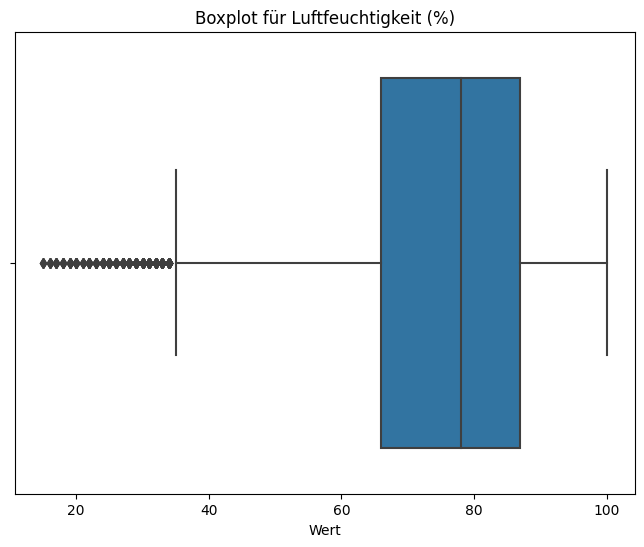

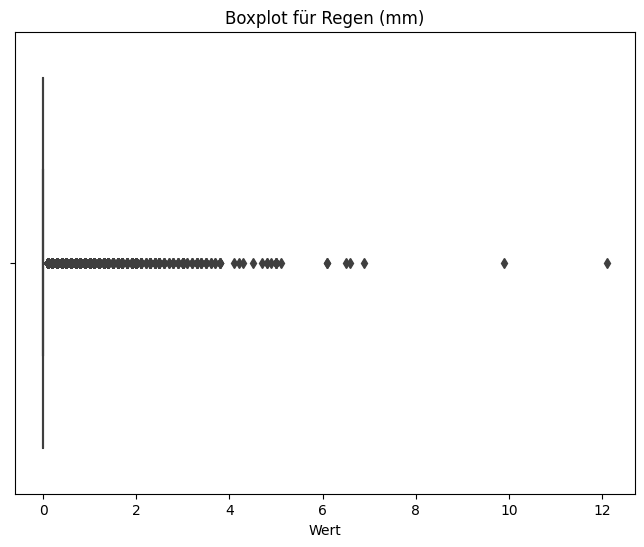

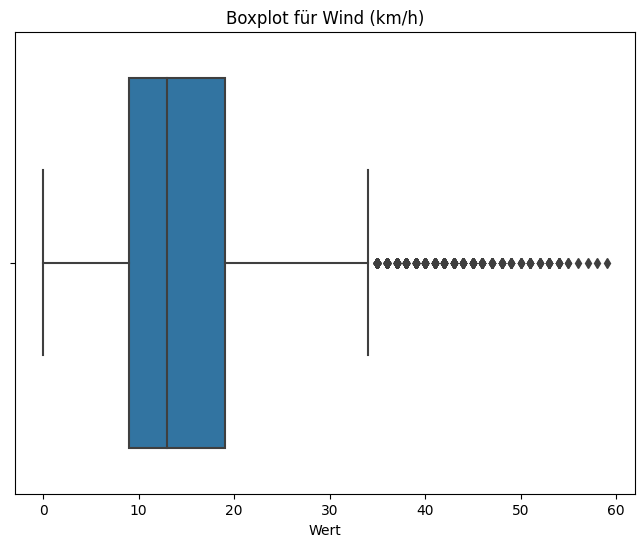

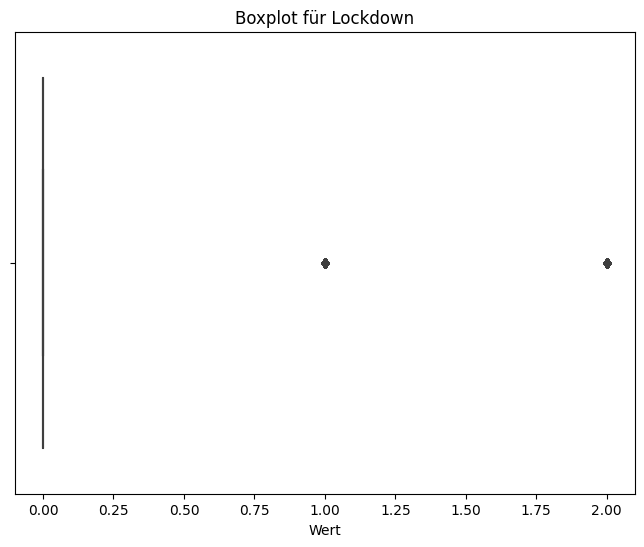

In [12]:
for col in df_neutor_numeric:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df_neutor[col])
    plt.title(f'Boxplot für {col}')
    plt.xlabel('Wert')
    plt.show()

Kontrollieren, ob die Ausreißer falsche Werte sind oder ob die realistisch sind

In [14]:
def top_10_rows_per_column(df):
    top_and_bottom_10_df_list = []
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        top_10_rows = df.nlargest(10, column).copy()
        top_10_rows['Extreme Value'] = 'Max'
        top_10_rows['Column'] = column

        bottom_10_rows = df.nsmallest(10, column).copy()
        bottom_10_rows['Extreme Value'] = 'Min'
        bottom_10_rows['Column'] = column

        top_and_bottom_10_df_list.extend([top_10_rows, bottom_10_rows])

    top_and_bottom_10_df = pd.concat(top_and_bottom_10_df_list)
    return top_and_bottom_10_df

top_10_df = top_10_rows_per_column(df_histo)
top_10_df


,Datum,Zeit,Wochentag,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts,Wetter,Temperatur (°C),Luftfeuchtigkeit (%),Regen (mm),Wind (km/h),Lockdown,Extreme Value,Column
4262,2018-06-27,15:00:00,Mittwoch,2414.0,1380.0,1034.0,Sonnig,23.0,53.0,0.0,18.0,0,Max,Neutor (gesamt)
4265,2018-06-27,18:00:00,Mittwoch,2205.0,913.0,1292.0,Sonnig,22.0,62.0,0.0,13.0,0,Max,Neutor (gesamt)
11103,2019-04-08,17:00:00,Montag,1996.0,930.0,1066.0,Leicht bewölkt,16.0,54.0,0.0,15.0,0,Max,Neutor (gesamt)
6904,2018-10-15,17:00:00,Montag,1988.0,949.0,1039.0,Leicht bewölkt,21.0,62.0,0.0,6.0,0,Max,Neutor (gesamt)
3064,2018-05-08,17:00:00,Dienstag,1918.0,938.0,980.0,Sonnig,21.0,63.0,0.0,18.0,0,Max,Neutor (gesamt)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2018-01-01,05:00:00,Montag,88.0,15.0,73.0,Stellenweiser Regenfall,8.0,74.0,0.0,33.0,0,Min,Lockdown
6,2018-01-01,06:00:00,Montag,37.0,11.0,26.0,Stellenweiser Regenfall,8.0,72.0,0.0,35.0,0,Min,Lockdown
7,2018-01-01,07:00:00,Montag,23.0,8.0,15.0,Stellenweiser Regenfall,7.0,73.0,0.0,33.0,0,Min,Lockdown
8,2018-01-01,08:00:00,Montag,11.0,3.0,8.0,Bedeckt,7.0,73.0,0.0,32.0,0,Min,Lockdown


In [15]:
neutor_nach_zeit = df_neutor.groupby('Zeit').agg({
    'Neutor (gesamt)': 'mean',
    'Neutor FR stadteinwärts': 'mean',
    'Neutor FR stadtauswärts': 'mean'
    }).reset_index()

neutor_nach_zeit_sortiert = neutor_nach_zeit.sort_values(by='Neutor (gesamt)').reset_index(drop=True)
neutor_nach_zeit_sortiert


,Zeit,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts
0,04:00:00,34.514124,12.343891,22.989461
1,03:00:00,44.552855,11.609508,34.113517
2,05:00:00,54.515493,32.133033,23.265652
3,02:00:00,64.074872,17.413969,48.296948
4,01:00:00,93.899321,29.099094,67.071387
5,00:00:00,139.843326,46.724802,96.387946
6,06:00:00,141.024789,93.980271,48.916325
7,23:00:00,199.932844,70.143986,134.772115
8,22:00:00,270.087887,99.518038,177.215331
9,21:00:00,309.593239,128.072153,188.606202


In [16]:
outliers_df = pd.DataFrame()

for col in df_neutor_numeric:
    z_score = zscore(df_neutor_numeric[col], nan_policy='omit')
    outliers = df_neutor_numeric[np.abs(z_score) > 3]
    
    outliers_df = pd.concat([outliers_df, outliers], ignore_index=True)
    
outliers_df

,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts,Temperatur (°C),Luftfeuchtigkeit (%),Regen (mm),Wind (km/h),Lockdown
0,1572.0,723.0,849.0,20.0,61.0,0.0,17.0,0
1,1591.0,709.0,882.0,19.0,68.0,0.0,12.0,0
2,1539.0,708.0,831.0,15.0,80.0,1.0,24.0,0
3,1908.0,858.0,1050.0,16.0,66.0,0.0,13.0,0
4,1546.0,704.0,842.0,15.0,68.0,0.0,12.0,0
...,...,...,...,...,...,...,...,...
6703,376.0,188.0,188.0,10.0,69.0,0.0,8.0,2
6704,346.0,167.0,179.0,9.0,71.0,0.0,10.0,2
6705,213.0,87.0,126.0,8.0,73.0,0.0,12.0,2
6706,176.0,64.0,112.0,8.0,74.0,0.0,12.0,2


In [17]:
mean_values = df_neutor_numeric.mean()

std_values = df_neutor_numeric.std()

erste_std = mean_values - std_values
zweite_std = mean_values + std_values * 2
dritte_std = mean_values + std_values * 3

summary_df = pd.DataFrame({'Mittelwert': mean_values, 
                           'Standardabweichung': std_values, 
                           '1. Standardabweichung': erste_std,
                           '2. Standardabweichung': zweite_std,
                           '3. Standardabweichung': dritte_std})


summary_df

,Mittelwert,Standardabweichung,1. Standardabweichung,2. Standardabweichung,3. Standardabweichung
Neutor (gesamt),417.252185,361.151950,56.100235,1139.556085,1500.708034
Neutor FR stadteinwärts,212.731702,196.080084,16.651618,604.891869,800.971953
Neutor FR stadtauswärts,212.411261,178.504497,33.906764,569.420256,747.924754
Temperatur (°C),11.104140,7.316593,3.787547,25.737326,33.053918
Luftfeuchtigkeit (%),75.476721,14.800787,60.675934,105.078295,119.879082
Regen (mm),0.068489,0.287193,-0.218704,0.642874,0.930066
Wind (km/h),14.498973,7.628741,6.870232,29.756456,37.385197
Lockdown,0.210867,0.584531,-0.373664,1.379930,1.964461


In [18]:
summary_dict = {}

for col in df_neutor_numeric.columns:
    data = df_neutor_numeric[col]
    q1 = data.quantile(0.25)  # Unteres Quartil (25%)
    q3 = data.quantile(0.75)  # Oberes Quartil (75%)

    iqr = q3 - q1  # Interquartilabstand

    lower_whisker = q1 - 1.5 * iqr  # Untere Grenze
    upper_whisker = q3 + 1.5 * iqr  # Obere Grenze
    
    # Ausreißer
    lower_outliers = data[data < lower_whisker]
    upper_outliers = data[data > upper_whisker]

    summary_dict[col] = {
        'Untere Whisker-Grenze': lower_whisker,
        'Unteres Quartil (Q1)': q1,
        'Oberes Quartil (Q3)': q3,
        'Obere Whisker-Grenze': upper_whisker,
        'Anzahl der unteren Ausreißer': len(lower_outliers),
        'Anzahl der oberen Ausreißer': len(upper_outliers),
    }

summary_df_neutor = pd.DataFrame(summary_dict)

summary_df_neutor

,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts,Temperatur (°C),Luftfeuchtigkeit (%),Regen (mm),Wind (km/h),Lockdown
Untere Whisker-Grenze,-725.5,-420.5,-334.5,-11.5,34.5,0.0,-6.0,0.0
Unteres Quartil (Q1),98.0,37.0,57.0,5.0,66.0,0.0,9.0,0.0
Oberes Quartil (Q3),647.0,342.0,318.0,16.0,87.0,0.0,19.0,0.0
Obere Whisker-Grenze,1470.5,799.5,709.5,32.5,118.5,0.0,34.0,0.0
Anzahl der unteren Ausreißer,0.0,0.0,0.0,41.0,363.0,0.0,0.0,0.0
Anzahl der oberen Ausreißer,348.0,201.0,494.0,117.0,0.0,6118.0,770.0,5400.0


In [19]:
mean_values_neutor = df_neutor['Neutor (gesamt)'].mean()
std_values_neutor = df_neutor['Neutor (gesamt)'].std()

grenzwert_3_std_neutor_g = mean_values_neutor + 3 * std_values_neutor

ausreisser_3_std_neutor_g = df_neutor[df_neutor['Neutor (gesamt)'] > grenzwert_3_std_neutor_g]

ausreisser_3_std_neutor_g

,Datum,Zeit,Wochentag,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts,Wetter,Temperatur (°C),Luftfeuchtigkeit (%),Regen (mm),Wind (km/h),Feiertag,Semesterferien,Ferien,Lockdown
2368,2018-04-09,17:00:00,Montag,1572.0,723.0,849.0,Leicht bewölkt,20.0,61.0,0.0,17.0,0,0,0,0
2392,2018-04-10,17:00:00,Dienstag,1591.0,709.0,882.0,Stellenweise Gewitter und Niederschläge,19.0,68.0,0.0,12.0,0,0,0,0
2416,2018-04-11,17:00:00,Mittwoch,1539.0,708.0,831.0,Leichter Regenschauer,15.0,80.0,1.0,24.0,0,0,0,0
2536,2018-04-16,17:00:00,Montag,1908.0,858.0,1050.0,Stellenweiser Regenfall,16.0,66.0,0.0,13.0,0,0,0,0
2537,2018-04-16,18:00:00,Montag,1546.0,704.0,842.0,Stellenweiser Regenfall,15.0,68.0,0.0,12.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42397,2022-11-02,17:00:00,Mittwoch,1504.0,675.0,829.0,Sonnig,14.0,66.0,0.0,16.0,0,0,0,0
42517,2022-11-07,17:00:00,Montag,1613.0,684.0,929.0,Bewölkt,13.0,73.0,0.0,23.0,0,0,0,0
42541,2022-11-08,17:00:00,Dienstag,1638.0,759.0,879.0,Bewölkt,15.0,55.0,0.0,27.0,0,0,0,0
42685,2022-11-14,17:00:00,Montag,1574.0,713.0,861.0,Sonnig,12.0,78.0,0.0,12.0,0,0,0,0


In [20]:
mean_values_neutor = df_neutor['Regen (mm)'].mean()
std_values_neutor = df_neutor['Regen (mm)'].std()

grenzwert_3_std_regen = mean_values_neutor + 3 * std_values_neutor

ausreisser_3_std_regen = df_neutor[df_neutor['Regen (mm)'] > grenzwert_3_std_neutor_g]

ausreisser_3_std_regen

,Datum,Zeit,Wochentag,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts,Wetter,Temperatur (°C),Luftfeuchtigkeit (%),Regen (mm),Wind (km/h),Feiertag,Semesterferien,Ferien,Lockdown


## Korrelation in den Daten

In [21]:
df_neutor_cor = df_neutor.copy()

df_neutor_cor['Zeit'] = pd.Categorical(df_neutor_cor['Zeit'])
df_neutor_cor['Zeit'] = df_neutor_cor['Zeit'].cat.codes

df_neutor_cor = df_neutor_cor[['Neutor (gesamt)', 'Neutor FR stadteinwärts', 'Neutor FR stadtauswärts', 'Temperatur (°C)', 'Luftfeuchtigkeit (%)',
                               'Regen (mm)', 'Wind (km/h)', 'Zeit']]

df_neutor_cor

,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts,Temperatur (°C),Luftfeuchtigkeit (%),Regen (mm),Wind (km/h),Zeit
0,71.0,26.0,45.0,10.0,83.0,1.0,26.0,0
1,67.0,35.0,32.0,9.0,81.0,1.0,27.0,1
2,123.0,53.0,70.0,9.0,79.0,1.0,29.0,2
3,171.0,64.0,107.0,8.0,77.0,0.0,31.0,3
4,102.0,26.0,76.0,8.0,75.0,0.0,32.0,4
...,...,...,...,...,...,...,...,...
43814,365.0,173.0,192.0,16.0,72.0,0.0,38.0,18
43815,303.0,164.0,139.0,16.0,70.0,0.0,37.0,19
43816,207.0,102.0,105.0,16.0,69.0,0.0,36.0,20
43817,149.0,83.0,66.0,15.0,67.0,0.0,36.0,21


In [22]:
df_neutor_cor.dtypes

Neutor (gesamt)            float64
Neutor FR stadteinwärts    float64
Neutor FR stadtauswärts    float64
Temperatur (°C)            float64
Luftfeuchtigkeit (%)       float64
Regen (mm)                 float64
Wind (km/h)                float64
Zeit                          int8
dtype: object

In [23]:
correlation_matrix = df_neutor_cor.corr(method='pearson')

correlation_matrix

,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts,Temperatur (°C),Luftfeuchtigkeit (%),Regen (mm),Wind (km/h),Zeit
Neutor (gesamt),1.000000,0.964566,0.969387,0.342210,-0.371846,-0.072129,0.023374,0.379168
Neutor FR stadteinwärts,0.964566,1.000000,0.890737,0.329788,-0.350702,-0.076833,0.023796,0.299757
Neutor FR stadtauswärts,0.969387,0.890737,1.000000,0.343564,-0.372595,-0.072082,0.015108,0.455479
Temperatur (°C),0.342210,0.329788,0.343564,1.000000,-0.495425,-0.012209,-0.120344,0.144782
Luftfeuchtigkeit (%),-0.371846,-0.350702,-0.372595,-0.495425,1.000000,0.179274,-0.049259,-0.242461
Regen (mm),-0.072129,-0.076833,-0.072082,-0.012209,0.179274,1.000000,0.156483,-0.005071
Wind (km/h),0.023374,0.023796,0.015108,-0.120344,-0.049259,0.156483,1.000000,0.057958
Zeit,0.379168,0.299757,0.455479,0.144782,-0.242461,-0.005071,0.057958,1.000000


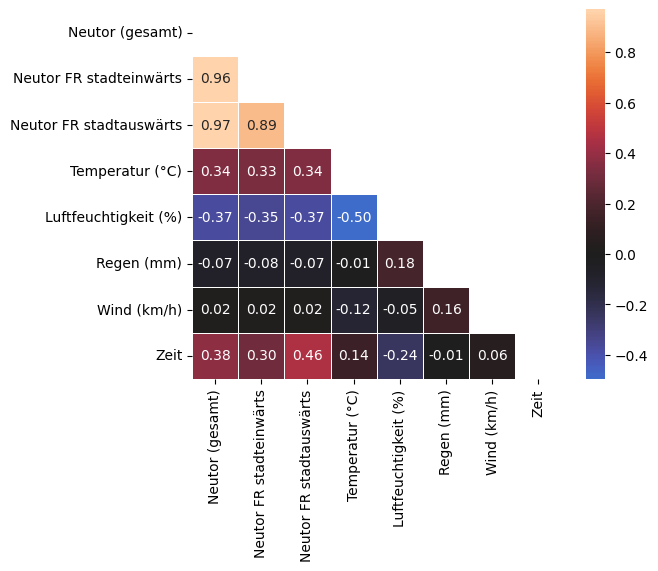

In [24]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask,
            annot=True, center=0,
            linewidths=.5, square=True, fmt=".2f")

plt.savefig('visualization/correlation.png', bbox_inches='tight', dpi=1000)

In [25]:
series = df_neutor_numeric['Neutor FR stadteinwärts']

series_dropped = series.dropna()

autocorr_coefficients = acf(series_dropped, nlags=24)

autocorr_coefficients

array([ 1.        ,  0.90210263,  0.75147532,  0.60164248,  0.46750131,
        0.34034153,  0.21010942,  0.09025789, -0.0085045 , -0.09435007,
       -0.18221496, -0.25870111, -0.29040867, -0.27404854, -0.21009336,
       -0.13013945, -0.0491913 ,  0.0432071 ,  0.15256251,  0.2698515 ,
        0.3828946 ,  0.50092506,  0.62878247,  0.75199433,  0.82243077])

### Autokorrelation kontrollieren

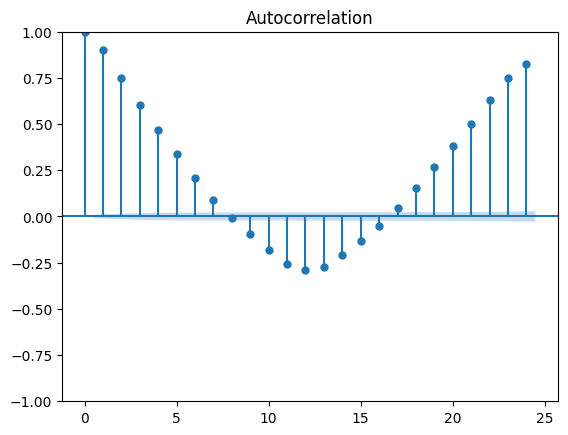

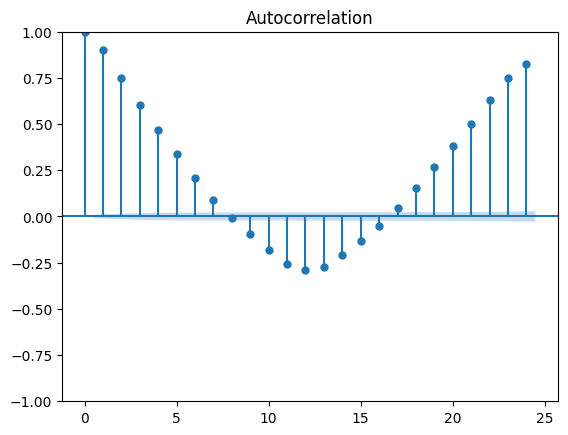

In [26]:
plot_acf(series_dropped, lags=24)


# Verlauf von Neutor (gesamt)

In [27]:
df_group_date = df_neutor.groupby('Datum').agg({'Neutor (gesamt)': 'sum', 'Neutor FR stadteinwärts': 'sum', 'Neutor FR stadtauswärts': 'sum'}).reset_index()
df_group_date['Neutor (gesamt)'].replace(0, np.nan, inplace=True)
df_group_date

,Datum,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts
0,2018-01-01,1909.0,850.0,1059.0
1,2018-01-02,4669.0,2289.0,2380.0
2,2018-01-03,4112.0,2000.0,2112.0
3,2018-01-04,5686.0,2796.0,2890.0
4,2018-01-05,6494.0,3329.0,3165.0
...,...,...,...,...
1821,2022-12-27,3777.0,1906.0,1871.0
1822,2022-12-28,3623.0,1824.0,1799.0
1823,2022-12-29,4107.0,2017.0,2090.0
1824,2022-12-30,4152.0,2118.0,2034.0


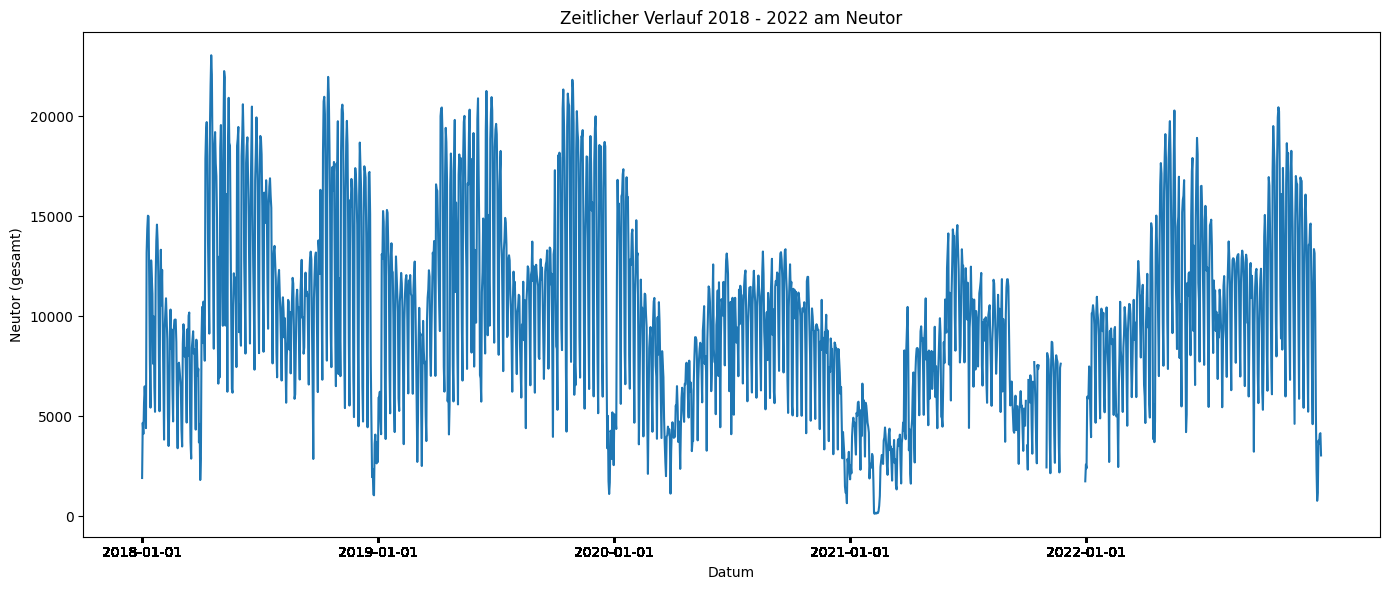

In [36]:
plt.figure(figsize=(14, 6))
plt.plot(df_group_date['Datum'], df_group_date['Neutor (gesamt)'])
plt.xticks([])
plt.ylabel('Neutor (gesamt)')
plt.xlabel('Datum')
plt.title('Zeitlicher Verlauf 2018 - 2022 am Neutor')
plt.xticks(rotation=45)
plt.xticks(df_group_date['Datum'].dt.strftime('%Y'))
plt.tight_layout()

plt.savefig('visualization/timeseries_18_22.png', bbox_inches='tight', dpi=1000)

plt.show()

# Saisonalität kontrollieren

/var/folders/hz/2fntg1q133z6s0ff1j1vhkgm0000gn/T/ipykernel_8444/4063829791.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


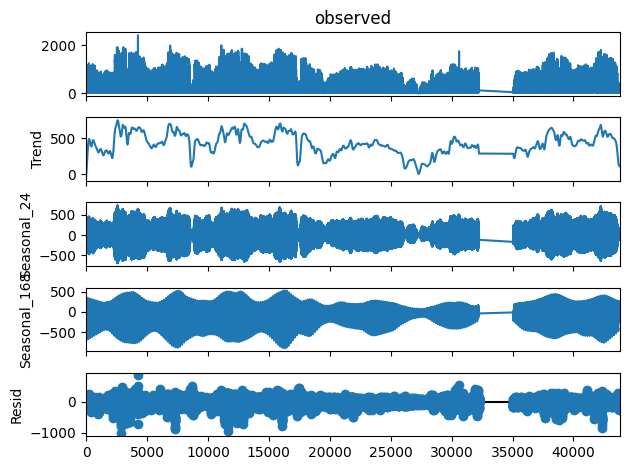

In [29]:
df_decom = df_neutor.dropna()
res = MSTL(df_decom['Neutor (gesamt)'], periods=(24, 24*7)).fit()
res.plot()
plt.tight_layout()
plt.show()

In [30]:
pp = PhillipsPerron(df_decom['Neutor (gesamt)'])
print(pp.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -36.489
P-value                         0.000
Lags                               54
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [31]:
pp = PhillipsPerron(df_decom['Neutor FR stadteinwärts'])
print(pp.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -41.437
P-value                         0.000
Lags                               54
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [32]:
pp = PhillipsPerron(df_decom['Neutor FR stadtauswärts'])
print(pp.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -38.636
P-value                         0.000
Lags                               54
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
